Url: https://tbrain.trendmicro.com.tw/Competitions/Details/2

In [3]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lag, rank, lit
from pyspark.sql.window import Window

In [1]:
global Path
if sc.master[0:5]=="local":
    Path = "file:/c:/D Drive/work/bigData/pySpark/TBrain_Round2_DataSet_20180427"
    #Path = "file:/Users/yungchuanlee/Documents/learn/AI競賽/ETF預測/TBrain_Round2_DataSet_20180331"
else:
    Path = "hdfs://master:9000/user/hduser"

In [13]:
float("    46.57")+float("     29,020".replace(",",""))

29066.57

In [2]:
#define alias of columns
col_alias_etf= {"代碼":"etf_id", "日期": "etf_date", "中文簡稱": "etf_name", "開盤價(元)":"etf_open", 
            "最高價(元)":"etf_high", "最低價(元)":"etf_low", "收盤價(元)":"etf_close", "成交張數(張)":"etf_count"}
col_alias_stock= {"代碼":"stock_id", "日期": "stock_date", "中文簡稱": "stock_name", "開盤價(元)":"stock_open", 
            "最高價(元)":"stock_high", "最低價(元)":"stock_low", "收盤價(元)":"stock_close", "成交張數(張)":"stock_count"}

In [4]:
#udf
def to_double(str_val):
    return float(str_val.replace(",",""))
to_double=udf(to_double)

In [5]:
#def function to read data (因檔案格式都相同)
def read_data(file_name, col_alias):
    str_cols = ["代碼","日期", "中文簡稱"]
    raw_data = spark.read.option("encoding", "Big5").csv(Path + "/" + file_name, header=True, sep=",")
    print("Total " + file_name + " count: " + str(raw_data.count()))
    #rename cols and correct type 
    num_cols = [col_name for col_name in raw_data.columns if col_name not in str_cols]
    final_data=raw_data.select( [col(str_col_name).alias(col_alias[str_col_name]) for str_col_name in str_cols] + 
                                  [to_double(col(num_col_name)).cast("double").alias(col_alias[num_col_name]) for num_col_name in num_cols] )
    final_data.printSchema()
    final_data.show(5)
    return final_data

In [6]:
print("starting import tetfp.csv(台灣18檔ETF股價資料)...")
tetfp_dt=read_data("tetfp.csv", col_alias_etf)

starting import tetfp.csv(台灣18檔ETF股價資料)...
Total tetfp.csv count: 19054
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |    54.0|   54.65|   53.9|     54.4|  16487.0|
|0050   |20130103|元大台灣50          |    54.9|   55.05|  54.65|    54.85|  29020.0|
|0050   |20130104|元大台灣50          |   54.85|   54.85|   54.4|     54.5|   9837.0|
|0050   |20130107|元大台灣50          |   54.55|   54.55|   53.9|    54.25|   8910.0|
|0050   |20130108|元大台灣50     

In [7]:
#EDA
#range of date
tetfp_dt.describe('etf_date').show()

+-------+--------------------+
|summary|            etf_date|
+-------+--------------------+
|  count|               19054|
|   mean|2.0153294704733916E7|
| stddev|  15718.272009667517|
|    min|            20130102|
|    max|            20180427|
+-------+--------------------+



In [127]:
print("starting import taetfp.csv(台灣18檔ETF調整後股價資料)...")
taetfp_dt=read_data("taetfp.csv", col_alias_etf)

starting import taetfp.csv(台灣18檔ETF調整後股價資料)...
Total taetfp.csv count: 18747
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |   46.57|   47.13|  46.49|    46.92|  16487.0|
|0050   |20130103|元大台灣50          |   47.35|   47.48|  47.13|    47.31|  29020.0|
|0050   |20130104|元大台灣50          |   47.31|   47.31|  46.92|     47.0|   9837.0|
|0050   |20130107|元大台灣50          |   47.05|   47.05|  46.49|    46.79|   8910.0|
|0050   |20130108|元大台灣50

In [128]:
print("starting import tsharep.csv(台灣個股股價資料)...")
tsharep_dt=read_data("tsharep.csv", col_alias_stock)

starting import tsharep.csv(台灣個股股價資料)...
Total tsharep.csv count: 1983973
root
 |-- stock_id: string (nullable = true)
 |-- stock_date: string (nullable = true)
 |-- stock_name: string (nullable = true)
 |-- stock_open: double (nullable = true)
 |-- stock_high: double (nullable = true)
 |-- stock_low: double (nullable = true)
 |-- stock_close: double (nullable = true)
 |-- stock_count: double (nullable = true)

+--------+----------+------------------+----------+----------+---------+-----------+-----------+
|stock_id|stock_date|        stock_name|stock_open|stock_high|stock_low|stock_close|stock_count|
+--------+----------+------------------+----------+----------+---------+-----------+-----------+
| 1101   |  20130102|台泥                |     38.95|      39.1|    38.65|       39.0|     6374.0|
| 1101   |  20130103|台泥                |      39.5|      39.5|    38.75|      38.85|     9710.0|
| 1101   |  20130104|台泥                |      39.4|     39.45|     38.6|       39.0|     8682.0|
| 1

In [129]:
print("starting import tasharep.csv(台灣個股調整後股價資料)...")
tasharep_dt=read_data("tasharep.csv", col_alias_stock)

starting import tasharep.csv(台灣個股調整後股價資料)...
Total tasharep.csv count: 1983973
root
 |-- stock_id: string (nullable = true)
 |-- stock_date: string (nullable = true)
 |-- stock_name: string (nullable = true)
 |-- stock_open: double (nullable = true)
 |-- stock_high: double (nullable = true)
 |-- stock_low: double (nullable = true)
 |-- stock_close: double (nullable = true)
 |-- stock_count: double (nullable = true)

+--------+----------+------------------+----------+----------+---------+-----------+-----------+
|stock_id|stock_date|        stock_name|stock_open|stock_high|stock_low|stock_close|stock_count|
+--------+----------+------------------+----------+----------+---------+-----------+-----------+
| 1101   |  20130102|台泥                |     30.41|     30.53|    30.18|      30.45|     6374.0|
| 1101   |  20130103|台泥                |     30.84|     30.84|    30.25|      30.33|     9710.0|
| 1101   |  20130104|台泥                |     30.76|      30.8|    30.14|      30.45|     8682.0

In [16]:
import sys
from pyspark.sql.functions import lag, col, avg,collect_list, lit
from pyspark.sql.window import Window
#declare previous row windows
wsSpec_etf = Window.partitionBy('etf_id').orderBy('etf_date') #time window for normal case
wsSpec_etf_close_price_raw = Window.partitionBy('etf_id').orderBy('row_idx').rangeBetween(-sys.maxsize, -1)
def avg_list(p_list):
    #計算數字list的平均值
    return sum(p_list)/len(p_list)
#計算EMA的udf
def calculate_ema(close_p_list, window_len):
    #透過歷史收盤價計算
    if len(close_p_list) < window_len:
        return None
    elif len(close_p_list) == window_len:
        #if len of list = win_len then return avg, 
        return avg_list(close_p_list)
    else:
        #else EMA[t] =(EMA[t-1]*(win_len-1)+close[t]*2)/(win_len+1)
        ema = avg_list(close_p_list[:window_len])
        for price in close_p_list[window_len:]:
            ema = (ema*(window_len-1)+price*2)/(window_len+1)
        return ema
calculate_ema=udf(calculate_ema)
#計算BIAS的udf
def calculate_bias(close_p_list):
    #計算前日收盤價與N日均線之差比: (close price - MA)/MA   ,Paper 建議用20日MA
    #因要預測今日的收盤價，故計算前日收盤價與前20日均線
    if len(close_p_list) < 21:
        return None
    else:
        list_len = len(close_p_list)
        p_close = close_p_list[-1]
        cal_list = close_p_list[list_len-21: list_len-1]
        return p_close - avg_list(cal_list)
calculate_bias=udf(calculate_bias)
#計算當日收盤價與前一日收盤價差
def calculate_close_diff(p_close, close_p_list):
    if len(close_p_list) == 0:
        return None
    else:
        return p_close - close_p_list[-1]
calculate_close_diff=udf(calculate_close_diff)
def get_min_max_last(p_list):
    #找出list中最大最小和最後一個值, 回傳(min, max, last)
    return (min(p_list), max(p_list), p_list[-1])
def calculate_raw_rsv(p_list):
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    p_min, p_max, p_last = get_min_max_last(p_list)
    rsv = (p_list - p_min)/(p_max - p_min)
    return rsv
def calculate_rsv(p_9_list, k_prev, d_prev):
    #計算加權後的RSV，p_9_list=>9日收盤價
    rrsv = calculate_raw_rsv(p_9_list)
    k_curr = (1/3)*rrsv + (2/3)*k_prev
    d_curr = (1/3)*k_curr + (2/3)*d_prev
    return (k_curr, d_curr)
    
#計算隨機指標（Stochastic Oscillator，KD），原名%K&%D
def calculate_KD(close_p_list):
    win_len = 9 #看過去 9 日值
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    #K_curr = 1/3*RSV + 2/3*K_prev
    #D_curr = 1/3*K_curr + 2/3*D_prev
    if len(close_p_list) < win_len:
        return None
    elif len(close_p_list) == win_len:
        #無前日K, D時，以0.5帶入
        return calculate_rsv(close_p_list, 0.5, 0.5)
    else:
        k_curr, d_curr = 
        for idx in range(0, (len(close_p_list)+1-9)):
            

In [17]:
#calculate ema [5,10,20] #cannot remove row_idx, row_idx for next window usage
tetfp_dt2=tetfp_dt.withColumn("row_idx", rank().over(wsSpec_etf)) \
    .withColumn("close_price_raw", collect_list(col('etf_close')).over(wsSpec_etf_close_price_raw)) \
    .withColumn("EMA5", calculate_ema(col("close_price_raw"), lit(5)).cast("double")) \
    .withColumn("EMA10", calculate_ema(col("close_price_raw"), lit(10)).cast("double")) \
    .withColumn("EMA20", calculate_ema(col("close_price_raw"), lit(20)).cast("double")) \
    .withColumn("BIAS", calculate_bias(col("close_price_raw")).cast("double")) \
    .withColumn("close_diff", calculate_close_diff(col("etf_close"),col("close_price_raw")).cast("double"))
    
tetfp_dt2.printSchema()
tetfp_dt2.filter("etf_id='0050   '").select("row_idx" ,"etf_close", "EMA5", "EMA10", "EMA20", "BIAS", "close_diff") \
            .show(35)
#          .toPandas().to_csv(Path.replace("file:","") + "/taetfp_BIAS.csv",index=False)


root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)
 |-- row_idx: integer (nullable = true)
 |-- close_price_raw: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- EMA5: double (nullable = true)
 |-- EMA10: double (nullable = true)
 |-- EMA20: double (nullable = true)
 |-- BIAS: double (nullable = true)
 |-- close_diff: double (nullable = true)

+-------+---------+------------------+------------------+------------------+-------------------+--------------------+
|row_idx|etf_close|              EMA5|             EMA10|             EMA20|               BIAS|          close_diff|
+-------+---------+------------------+------------------+------------------+-------------------+--------------------+

In [18]:
#匯出成pandas
etf_pd_50 = tetfp_dt2.filter("etf_id='0050   '").select("row_idx", "etf_date" ,"etf_close", "EMA5", "EMA10", "EMA20", "BIAS") \
                .toPandas()

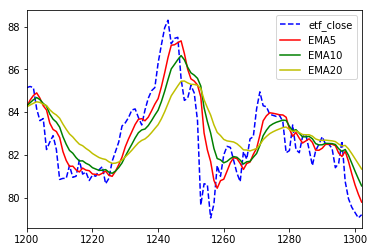

In [19]:
#圖形化顯示
#aetf_pd_50.set_index('etf_date') #set_index 後配合 loc select 出區段資料來看
etf_pd_50_part = etf_pd_50.loc[1200:]
etf_pd_50_part.etf_close.plot(x='row_idx', y='etf_close', style='b--', label="etf_close")
etf_pd_50_part.EMA5.plot(x='row_idx', y='EMA5', label="EMA5", style='r-')
etf_pd_50_part.EMA10.plot(x='row_idx', y='EMA10', label="EMA10", style='g-')
etf_pd_50_part.EMA20.plot(x='row_idx', y='EMA20', label="EMA20", style='y-')
plt.legend()
plt.show()

In [20]:
#計算各欄位與收盤價之相關性
corr_cols = ['EMA5','EMA10','EMA20','BIAS']
for col in corr_cols:
    print('corr between ', col , ' and etf_close: ', str(tetfp_dt2.corr(col, 'etf_close')))
print('corr between BIAS and etf_close_diff: ', str(tetfp_dt2.corr('BIAS', 'close_diff')))

corr between  EMA5  and etf_close:  0.9903396716685617
corr between  EMA10  and etf_close:  0.9811876234371903
corr between  EMA20  and etf_close:  0.9640948902379288
corr between  BIAS  and etf_close:  0.10899567830506812
corr between BIAS and etf_close_diff:  -0.04429838763677454


In [26]:
#ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66, 47.0, 46.96, 47.0]
ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66]
win_len=5
print(ll[: win_len])
for x in ll[win_len:]:
    print(x)
ema = sum(ll[:win_len])/len(ll[:win_len])
print(ema)
for price in ll[win_len:]:
    ema = (ema*(win_len-1)+price*2)/(win_len+1)
tup1, tup2 = (1,2)
print(tup1, ' ', tup2)
tup = (3,4)
print(tup[0], ' ', tup[1])
list(range(0,2))

[46.92, 47.31, 47.0, 46.79, 46.49]
46.66
46.902
1   2
3   4


[0, 1]